In [1]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from bayesian_torch.models.deterministic.resnet import resnet20 as resnet20_deterministic
from models import LeNet5
dnn = LeNet5()
dnn.load_state_dict(torch.load('runs/mnist/lenet/20241110/dnn/bs_512_lr_0.001_mc_runs_1_temp_1.0_epochs_30_kd_False_martern_False_alpha_0.0_moped_False_multi_moped_False_timestamp_20241110-045538/best_model.pth'))
dnn.eval().cuda()
from utils import get_dataset
import matplotlib.pyplot as plt
from termcolor import colored
class opt:
    
    bs = 1
    data = 'mnist'
    multi_gpu = False
    
args = opt()
train_loader, test_loader = get_dataset(args)

Data augmentaion is disabled


In [2]:
# # Check Sparsity
# def check_sparsity(model):
#     total = 0
#     zeros = 0
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             total += param.numel()
#             zeros += torch.sum(param == 0)
#     return zeros / total

# print(check_sparsity(dnn))

# 대각성분만 모델링

In [11]:
import torch
import numpy as np
from glob import glob
import re

# 숫자를 기준으로 정렬하는 함수
def sort_by_iteration(files):
    def extract_number(file_name):
        match = re.search(r"iter_(\d+)\.pth", file_name)
        return int(match.group(1)) if match else float("inf")
    return sorted(files, key=extract_number)

# 특정 레이어의 가중치 추출 함수
def extract_weights(weights_list, ckpt, layer_key):
    
    layer_weights = []  # 특정 레이어의 가중치를 저장할 리스트

    for file_path in weights_list:
        # 체크포인트 파일 로드
        ckpt = torch.load(file_path)

        # 특정 레이어의 가중치만 추출
        layer_weights.append(ckpt[layer_key].flatten().cpu().numpy())  # GPU -> CPU -> numpy

    return np.array(layer_weights)

# 실행 코드
weights_list = glob('runs/mnist/lenet/20241110/dnn/bs_1024_lr_0.001_mc_runs_1_temp_1.0_epochs_100_kd_False_martern_False_alpha_0.0_moped_False_multi_moped_False_timestamp_20241110-230714/prune*.pth')
weights_list = sort_by_iteration(weights_list)

# conv1.weight 가중치만 저장
ckpt = torch.load(weights_list[0])
layer_key = [key for key in ckpt.keys() if 'weight' in key]

def get_survival_time(pruning_info):
    
    '''
    Calculate index of zero weights in each weight in the pruning_info
    pruning_info: np.array object contains [NUM_ITERATION, WEIGHT_FLATTEN]
    return: survival time of each weight [WEIGHT_FLATTEN]
    '''
    
    survival_time = np.count_nonzero(pruning_info, axis=0)
    
    return survival_time

def calculate_variance(survival_time):
    
    variance = 1/(survival_time)
    return variance

for idx, layer_name in enumerate(layer_key):
    conv_weights = extract_weights(weights_list, ckpt, layer_name)
    survival_time = get_survival_time(conv_weights)
    variance = calculate_variance(survival_time)
    torch.save(torch.tensor(variance), f'variance_{layer_name}.pth')
    # plt.subplot(1, len(layer_key), idx+1)
    # plt.imshow(np.diag(variance))
    # plt.colorbar(fraction=0.046, pad=0.04)
    # break
    
    
    


[0.01123596 0.01136364 0.01149425 0.01162791 0.01176471 0.01190476
 0.01204819 0.01219512 0.01234568 0.0125     0.01265823 0.01282051
 0.01298701 0.01315789 0.01333333 0.01351351 0.01369863 0.01388889
 0.01408451 0.01428571 0.01449275 0.01470588 0.01492537 0.01515152
 0.01538462 0.015625   0.01587302 0.01612903 0.01639344 0.01666667
 0.01694915 0.01724138 0.01754386 0.01785714 0.01818182 0.01851852
 0.01886792 0.01923077 0.01960784 0.02       0.02040816 0.02083333
 0.0212766  0.02173913 0.02222222 0.02272727 0.02325581 0.02380952
 0.02439024 0.025      0.02564103 0.02631579 0.02702703 0.02777778
 0.02857143 0.02941176 0.03030303 0.03125    0.03225806 0.03333333
 0.03448276 0.03571429 0.03703704 0.03846154 0.04       0.04166667
 0.04347826 0.04545455 0.04761905 0.05       0.05263158 0.05555556
 0.05882353 0.0625     0.06666667 0.07142857 0.07692308 0.08333333
 0.09090909 0.1        0.11111111 0.125      0.14285714 0.16666667
 0.2        0.25       0.33333333 0.5        1.        ]


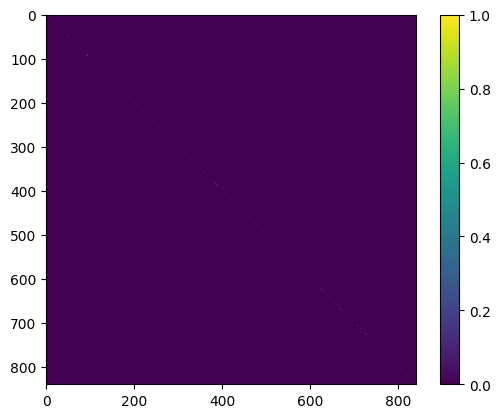

In [10]:
plt.imshow(np.diag(variance))
plt.colorbar()
print(np.unique(variance))

In [ ]:

# for layer_name in layer_name:
#     print(f"{layer_name} is processing...")
#     conv1_weights = extract_weights(weights_list, layer_name)
#     # 결과 출력
#     print(f"Number of files processed: {len(weights_list)}")
#     print(f"Number of weights extracted for {layer_name}: {len(conv1_weights)}")

#     # CNN 가중치 생존 여부 평가 함수
#     def calculate_pruning_info(weights, threshold=0.0):
#         """
#         Calculate the pruning information for each weight.
#         Args:
#             weights: List of numpy arrays containing weights for each iteration.
#             threshold: Values below this are considered pruned.
#         Returns:
#             pruning_info: Dictionary with weight indices as keys and survival status as values.
#         """
#         weights_array = np.array(weights)  # Shape: (num_iterations, num_weights)
#         num_iterations, num_weights = weights_array.shape

#         pruning_info = {}

        
#         # 각 가중치에 대해 프루닝 정보 생성
#         for weight_idx in range(num_weights):
#             survival_status = [
#                 1 if abs(weights_array[t, weight_idx]) > threshold else 0
#                 for t in range(num_iterations)
#             ]
#             pruning_info[f"w{weight_idx + 1}"] = survival_status

#         return pruning_info

#     # Flatten된 weights를 기반으로 pruning_info 계산
#     pruning_info = calculate_pruning_info(conv1_weights, threshold=1e-6)

#     # 생존 시간 계산
#     survival_time = calculate_survival_time(pruning_info)
#     # print(survival_time)
#     covariance_matrix = calculate_variance(survival_time)
    
#     # Check the covariance_matrix is PSD
#     eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
#     real_eigenvalues = eigenvalues.real  # 실수부 추출
#     is_psd = torch.all(real_eigenvalues >= 0)
#     assert is_psd, "NOT PSD MATRIX"

#     file_path = f'{layer_name}_variance.pt'
#     torch.save(covariance_matrix.diag(), file_path)
#     print(colored(f"saved at {file_path}", 'blue')) 


In [ ]:
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
real_eigenvalues = eigenvalues.real  # 실수부 추출
is_psd = torch.all(real_eigenvalues >= 0)

print(is_psd)

In [81]:

L_target = torch.cholesky(covariance_matrix)

In [ ]:
covariance_matrix.diag().shape

In [ ]:
from bayesian_torch.layers.variational_layers.conv_variational import Conv2dReparameterization_Multivariate, Conv2dReparameterization
from torch.distributions import LowRankMultivariateNormal, kl_divergence, Normal

bnn_layer = Conv2dReparameterization(
    in_channels=1,
    out_channels=6,
    kernel_size=5,
    stride=1,
    padding=0,
    # rank=1
).cuda()

optimizer = torch.optim.Adam(bnn_layer.parameters(), lr=0.001)

for i in range(10000):
    
    mu_kernel, sigma_weight = bnn_layer.mu_kernel, torch.log1p(torch.exp(bnn_layer.rho_kernel))

    dist1 = Normal(mu_kernel.view(-1).cuda(), sigma_weight.view(-1).cuda())
    
    dist2 = Normal(dnn.conv1.weight.view(-1).cuda(), covariance_matrix.diag().cuda())
    
    # print(mu_kernel.view(-1).shape, sigma_weight.view(-1).shape, dnn.conv1.weight.view(-1).shape, covariance_matrix.diag().shape)
    loss = kl_divergence(dist1, dist2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(loss.item())
        

In [ ]:
variance_matrix = calculate_variance(survival_time)

i=120
plt.imshow(variance_matrix[:9*i,:9*i])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_survival_time(pruning_info):
    """
    가중치의 생존 시간을 계산합니다.
    Args:
        pruning_info: 각 가중치의 프루닝 정보를 담은 딕셔너리.
    Returns:
        survival_time: 각 가중치의 생존 시간 딕셔너리.
    """
    survival_time = {
        key: max(np.sum(trajectory) - 1, 0)
        for key, trajectory in pruning_info.items()
    }
    return survival_time

def calculate_overlap(survival_time):
    """
    생존 시간을 기반으로 Overlap 행렬을 계산합니다.
    Args:
        survival_time: 각 가중치의 생존 시간 딕셔너리.
    Returns:
        overlap_matrix: Overlap 행렬 (numpy 배열).
        keys: 가중치의 키 리스트.
    """
    keys = list(survival_time.keys())
    times = np.array([survival_time[key] for key in keys])
    overlap_matrix = np.minimum.outer(times, times) + 1  # Overlap 계산
    return overlap_matrix, keys

def calculate_correlation(overlap_matrix, survival_time, keys):
    """
    Overlap 행렬을 기반으로 상관 계수 행렬을 계산합니다.
    Args:
        overlap_matrix: Overlap 행렬.
        survival_time: 각 가중치의 생존 시간 딕셔너리.
        keys: 가중치의 키 리스트.
    Returns:
        correlation_matrix: 상관 계수 행렬.
    """
    times = np.array([survival_time[key] for key in keys])
    max_time_matrix = np.maximum.outer(times, times) + 1  # 최대 생존 시간 계산

    # 상관 계수 행렬 계산
    with np.errstate(divide='ignore', invalid='ignore'):
        correlation_matrix = np.true_divide(
            overlap_matrix,
            max_time_matrix
        )
        correlation_matrix[max_time_matrix == 0] = 0  # 0으로 나누는 경우 처리

    return correlation_matrix

def calculate_covariance(correlation_matrix, survival_time, keys):
    """
    생존 시간을 기반으로 공분산 행렬을 계산합니다.
    대칭 행렬의 특성을 활용하여 메모리 사용량과 계산 시간을 최소화합니다.
    
    Args:
        correlation_matrix: 대칭 상관 계수 행렬.
        survival_time: 각 가중치의 생존 시간 딕셔너리.
        keys: 가중치 키 리스트.
    Returns:
        covariance_matrix: 공분산 행렬.
    """
    print("Starting covariance matrix calculation...")

    # 생존 시간 배열 생성
    times = np.array([survival_time[key] for key in keys], dtype=np.float32)
    n = len(times)
    print(f"Survival time array created: {times}")

    # 분산 계산
    variance = np.where(times > 0, 1 / (1 + times), 1)
    print(f"Variance array calculated: {variance}")

    # 공분산 행렬 초기화
    covariance_matrix = np.diag(variance)
    print("Covariance matrix initialized with diagonal variance values.")

    # 상삼각 부분 인덱스 추출
    upper_indices = np.triu_indices(n, k=1)
    i_indices, j_indices = upper_indices
    print(f"Upper triangular indices calculated: {len(i_indices)} pairs.")

    # 생존 시간이 있는 가중치 쌍 필터링
    positive_mask = (times[i_indices] > 0) & (times[j_indices] > 0)
    print(f"Positive mask for non-zero survival time created: {positive_mask.sum()} pairs.")

    # 상관 계수 값 추출 및 할당
    corr_values = correlation_matrix[i_indices[positive_mask], j_indices[positive_mask]]
    covariance_matrix[i_indices[positive_mask], j_indices[positive_mask]] = corr_values
    print("Upper triangular covariance values assigned.")

    # 대칭성 복원
    covariance_matrix = covariance_matrix + covariance_matrix.T - np.diag(covariance_matrix.diagonal())
    print("Covariance matrix symmetry restored.")

    print("Covariance matrix calculation completed.")
    return covariance_matrix


# ===========================
# 예시 데이터로 코드 테스트
# ===========================

# 가중치 프루닝 정보 (예시)
pruning_info = {
    "w1": [0, 0, 0, 0],  # w1: 처음부터 프루닝됨
    "w2": [1, 0, 0, 0],  # w2: 첫 번째 단계까지 생존
    "w3": [1, 1, 0, 0],  # w3: 두 번째 단계까지 생존
    "w4": [1, 1, 1, 0],  # w4: 세 번째 단계까지 생존
    "w5": [1, 1, 1, 1],  # w5: 끝까지 생존
}

# 1. 생존 시간 계산
survival_time = calculate_survival_time(pruning_info)

# 2. Overlap 및 상관 계수 행렬 계산
overlap_matrix, keys = calculate_overlap(survival_time)
correlation_matrix = calculate_correlation(overlap_matrix, survival_time, keys)

# 3. 공분산 행렬 계산
covariance_matrix = calculate_covariance(correlation_matrix, survival_time, keys)

# 결과 출력
print("Survival Time:", survival_time)
print("\nOverlap Matrix:\n", overlap_matrix)
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nCovariance Matrix:\n", covariance_matrix)

# 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Covariance Matrix")
plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
plt.title("Correlation Matrix")
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [9]:
# import numpy as np

# # 가중치 프루닝 정보를 담은 딕셔너리 (예시)
# pruning_info = {
#     "w1": [0, 0, 0, 0],  # w1: 처음부터 프루닝됨
#     "w2": [1, 0, 0, 0],  # w2: 첫 번째 단계까지 생존
#     "w3": [1, 1, 0, 0],  # w3: 두 번째 단계까지 생존
#     "w4": [1, 1, 1, 0],  # w4: 세 번째 단계까지 생존
#     "w5": [1, 1, 1, 1],  # w5: 끝까지 생존
# }

# # 생존 시간 계산 함수
# def calculate_survival_time(pruning_info):
#     survival_time = {}
#     for key, trajectory in pruning_info.items():
#         survival_time[key] = max(sum(trajectory) - 1, 0)  # 생존 시간 = 생존 단계 수 - 1 (0 이하 방지)
#     return survival_time

# # Overlap 계산 함수
# def calculate_overlap(survival_time):
#     keys = list(survival_time.keys())
#     overlap_matrix = np.zeros((len(keys), len(keys)))
#     for i, key_i in enumerate(keys):
#         for j, key_j in enumerate(keys):
#             overlap_matrix[i, j] = min(survival_time[key_i], survival_time[key_j]) + 1  # Overlap 계산
#     return overlap_matrix, keys

# # 상관계수 계산 함수
# def calculate_correlation(overlap_matrix, survival_time, keys):
#     correlation_matrix = np.zeros_like(overlap_matrix)
#     for i, key_i in enumerate(keys):
#         for j, key_j in enumerate(keys):
#             max_time = max(survival_time[key_i], survival_time[key_j]) + 1
#             correlation_matrix[i, j] = overlap_matrix[i, j] / max_time if max_time > 0 else 0
#     return correlation_matrix

# # 공분산 행렬 계산 함수
# def calculate_covariance(correlation_matrix, survival_time, keys):
#     variance = {key: 1 / (survival_time[key] + 1) for key in keys}  # 분산 계산
#     covariance_matrix = np.zeros_like(correlation_matrix)
#     for i, key_i in enumerate(keys):
#         for j, key_j in enumerate(keys):
#             covariance_matrix[i, j] = (
#                 correlation_matrix[i, j]
#                 * np.sqrt(variance[key_i] * variance[key_j])
#             )
#     return covariance_matrix

# # 생존 시간 계산
# survival_time = calculate_survival_time(pruning_info)

# # Overlap과 상관계수 계산
# overlap_matrix, keys = calculate_overlap(survival_time)
# correlation_matrix = calculate_correlation(overlap_matrix, survival_time, keys)

# # 공분산 행렬 계산
# covariance_matrix = calculate_covariance(correlation_matrix, survival_time, keys)

# # 결과 출력
# print("Survival Time:", survival_time)
# print("Overlap Matrix:\n", overlap_matrix)
# print("Correlation Matrix:\n", correlation_matrix)
# print("Covariance Matrix:\n", covariance_matrix)

# plt.imshow(covariance_matrix)
# plt.colorbar()

In [ ]:
import torch
import numpy as np
from glob import glob
import re

# 숫자를 기준으로 정렬하는 함수
def sort_by_iteration(files):
    def extract_number(file_name):
        match = re.search(r"iter_(\d+)\.pth", file_name)
        return int(match.group(1)) if match else float("inf")
    return sorted(files, key=extract_number)

# 특정 레이어의 가중치 추출 함수
def extract_weights(weights_list, layer_name='conv1.weight'):
    layer_weights = []  # 특정 레이어의 가중치를 저장할 리스트

    for file_path in weights_list:
        # 체크포인트 파일 로드
        ckpt = torch.load(file_path)

        # 특정 레이어의 가중치만 추출
        if layer_name in ckpt:
            layer_weights.append(ckpt[layer_name].flatten().cpu().numpy())  # GPU -> CPU -> numpy
        else:
            print(f"Warning: {layer_name} not found in {file_path}")

    return layer_weights

# 실행 코드
weights_list = glob('runs/mnist/lenet/20241110/dnn/bs_1024_lr_0.001_mc_runs_1_temp_1.0_epochs_100_kd_False_martern_False_alpha_0.0_moped_False_multi_moped_False_timestamp_20241110-230714/prune*.pth')
weights_list = sort_by_iteration(weights_list)

# conv1.weight 가중치만 저장
layer_name = 'conv1.weight'
conv1_weights = extract_weights(weights_list, layer_name)

# 결과 출력
print(f"Number of files processed: {len(weights_list)}")
print(f"Number of weights extracted for {layer_name}: {len(conv1_weights)}")

# 첫 번째 가중치의 크기 확인 (예시)



In [ ]:
# CNN 가중치 생존 여부 평가 함수
def calculate_pruning_info(weights, threshold=0.0):
    """
    Calculate the pruning information for each weight.
    Args:
        weights: List of numpy arrays containing weights for each iteration.
        threshold: Values below this are considered pruned.
    Returns:
        pruning_info: Dictionary with weight indices as keys and survival status as values.
    """
    weights_array = np.array(weights)  # Shape: (num_iterations, num_weights)
    num_iterations, num_weights = weights_array.shape

    pruning_info = {}

    # 각 가중치에 대해 프루닝 정보 생성
    for weight_idx in range(num_weights):
        survival_status = [
            1 if abs(weights_array[t, weight_idx]) > threshold else 0
            for t in range(num_iterations)
        ]
        pruning_info[f"w{weight_idx + 1}"] = survival_status

    return pruning_info

# Flatten된 weights를 기반으로 pruning_info 계산
pruning_info = calculate_pruning_info(conv1_weights, threshold=1e-6)

# 결과 출력
print("Pruning Info:")
for key, value in pruning_info.items():
    print(f"{key}: {value}")
    

# 생존 시간 계산
survival_time = calculate_survival_time(pruning_info)

# Overlap과 상관계수 계산
overlap_matrix, keys = calculate_overlap(survival_time)
correlation_matrix = calculate_correlation(overlap_matrix, survival_time, keys)

# 공분산 행렬 계산
covariance_matrix = calculate_covariance(correlation_matrix, survival_time, keys)

# 결과 출력
print("Survival Time:", survival_time)
print("Overlap Matrix:\n", overlap_matrix)
print("Correlation Matrix:\n", correlation_matrix)
print("Covariance Matrix:\n", covariance_matrix)

plt.imshow(covariance_matrix)
plt.colorbar()


In [ ]:
len(covariance_matrix)

In [10]:
# Chelesky Decomposition
L = np.linalg.cholesky(covariance_matrix + np.identity(len(covariance_matrix)) + 1e-10)

In [ ]:
idx=3
plt.imshow(covariance_matrix[:9*idx, :9*idx])
plt.colorbar()

#Check Covariance is PSD
if np.all(np.linalg.eigvals(covariance_matrix + np.identity(len(covariance_matrix)) + np.abs(np.min(covariance_matrix))) > 0):
    print('Covariance Matrix is PSD')
else:
    print('Covariance Matrix is not PSD')

In [12]:
# from torch.distributions import LowRankMultivariateNormal
# from bayesian_torch.layers.variational_layers.conv_variational import Conv2dReparameterization_Multivariate
# bayesian_cnn = Conv2dReparameterization_Multivariate(1, 6, 5, 1, 0, rank = 3)

# # _, D = bayesian_cnn.get_covariance_param()

# # L = torch.nn.Parameter(torch.Tensor(1*6*5*5).reshape(-1, 1), requires_grad=True)
# mu = torch.nn.Parameter(torch.Tensor(1*6*5*5), requires_grad=True)

# optimizer = torch.optim.Adam(bayesian_cnn.parameters(), lr=1e-3)

# pbar = tqdm(range(10000))
# for i in pbar:
    
#     L, D = bayesian_cnn.get_covariance_param()
#     mvn = LowRankMultivariateNormal(mu, L, D)
    
#     loss = (torch.tensor(covariance_matrix) - mvn.covariance_matrix).square().mean()
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     pbar.set_description(f'Loss: {loss.item()}')



In [13]:
# import torch
# import numpy as np
# from glob import glob
# import re

# # 숫자를 기준으로 정렬하는 함수
# def sort_by_iteration(files):
#     def extract_number(file_name):
#         match = re.search(r"iter_(\d+)\.pth", file_name)
#         return int(match.group(1)) if match else float("inf")
#     return sorted(files, key=extract_number)

# # 특정 레이어의 가중치 추출 함수
# def extract_weights(weights_list, layer_name='conv1.weight'):
#     layer_weights = []  # 특정 레이어의 가중치를 저장할 리스트

#     for file_path in weights_list:
#         # 체크포인트 파일 로드
#         ckpt = torch.load(file_path)

#         # 특정 레이어의 가중치만 추출
#         if layer_name in ckpt:
#             layer_weights.append(ckpt[layer_name].flatten().cpu().numpy())  # GPU -> CPU -> numpy
#         else:
#             print(f"Warning: {layer_name} not found in {file_path}")

#     return layer_weights

# # 실행 코드
WEIGHT_PATH = 'runs/mnist/lenet/20241110/dnn/bs_1024_lr_0.001_mc_runs_1_temp_1.0_epochs_100_kd_False_martern_False_alpha_0.0_moped_False_multi_moped_False_timestamp_20241110-230714/prune*.pth'
weights_list = glob(WEIGHT_PATH)
weights_list = sort_by_iteration(weights_list)

# # conv1.weight 가중치만 저장
# # layer_name = 'conv1.weight'
# ckpt = torch.load(weights_list[0])
# # Extract only 'weight' not 'bias
# layer_names = [key for key in ckpt.keys() if 'weight' in key]

# for layer_name in layer_names:
#     conv1_weights = extract_weights(weights_list, layer_name)
#     # print(layer_name)
#     print(conv1_weights[0].shape)
#     # 결과 출력
#     # print(f"Number of files processed: {len(weights_list)}")
#     # print(f"Number of weights extracted for {layer_name}: {len(conv1_weights)}")

#     # CNN 가중치 생존 여부 평가 함수
#     def calculate_pruning_info(weights, threshold=0.0):
#         """
#         Calculate the pruning information for each weight.
#         Args:
#             weights: List of numpy arrays containing weights for each iteration.
#             threshold: Values below this are considered pruned.
#         Returns:
#             pruning_info: Dictionary with weight indices as keys and survival status as values.
#         """
#         weights_array = np.array(weights)  # Shape: (num_iterations, num_weights)
#         num_iterations, num_weights = weights_array.shape

#         pruning_info = {}

#         # 각 가중치에 대해 프루닝 정보 생성
#         for weight_idx in range(num_weights):
#             survival_status = [
#                 1 if abs(weights_array[t, weight_idx]) > threshold else 0
#                 for t in range(num_iterations)
#             ]
#             pruning_info[f"w{weight_idx + 1}"] = survival_status

#         return pruning_info

#     # Flatten된 weights를 기반으로 pruning_info 계산
#     pruning_info = calculate_pruning_info(conv1_weights, threshold=1e-6)

#     # 결과 출력
#     # print("Pruning Info:")
#     # for key, value in pruning_info.items():
#         # print(f"{key}: {value}")

#     # 생존 시간 계산
#     survival_time = calculate_survival_time(pruning_info)

#     # Overlap과 상관계수 계산
#     overlap_matrix, keys = calculate_overlap(survival_time)
#     correlation_matrix = calculate_correlation(overlap_matrix, survival_time, keys)

#     # 공분산 행렬 계산
#     covariance_matrix = calculate_covariance(correlation_matrix, survival_time, keys)

#     # # 결과 출력
#     # print("Survival Time:", survival_time)
#     # print("Overlap Matrix:\n", overlap_matrix)
#     # print("Correlation Matrix:\n", correlation_matrix)
#     # print("Covariance Matrix:\n", covariance_matrix)

#     # plt.imshow(covariance_matrix)
#     # plt.colorbar()
#     torch.save(covariance_matrix, os.path.join(os.path.dirname(WEIGHT_PATH), f'{layer_name}_covariance_matrix.pth'), pickle_protocol=4)
#     print(f'{layer_name}_covariance_matrix.pth saved')

In [14]:
# # Check Covariance is PSD
# if np.all(np.linalg.eigvals(covariance_matrix + np.identity(len(covariance_matrix)) + np.abs(np.min(covariance_matrix))) > 0):
#     print('Covariance Matrix is PSD')
# else:
#     print('Covariance Matrix is not PSD')

In [ ]:
import numpy as np

def check_sparsity_by_zeros(matrix):
    """
    공분산 행렬의 희소성을 0의 개수로 체크합니다.
    
    Args:
        matrix (numpy.ndarray): 공분산 행렬.
        
    Returns:
        sparsity (float): 희소성 비율 (0~1, 1은 완전한 희소성).
        num_zeros (int): 0인 값의 개수.
        num_total (int): 전체 요소의 개수.
    """
    # 전체 요소의 개수
    num_total = matrix.size
    
    # 0인 값의 개수 계산
    num_zeros = np.count_nonzero(matrix == 0)

    # 희소성 비율 계산
    sparsity = num_zeros / num_total
    
    return sparsity, num_zeros, num_total

sparsity = check_sparsity_by_zeros(covariance_matrix)
print(sparsity)

In [ ]:
covariance_matrix = torch.tensor(torch.load(WEIGHT_PATH.replace('prune*', 'conv3.weight_covariance_matrix')))

e = torch.eye(covariance_matrix.shape[0]) + 1e-10
L = torch.cholesky(covariance_matrix + e)

In [ ]:
# Check Sparsity of L
total = 0
zeros = 0
sparsity = torch.count_nonzero(L == 0) / L.numel()
print(sparsity)


In [ ]:
from torch.distributions import LowRankMultivariateNormal
from bayesian_torch.layers.variational_layers.conv_variational import Conv2dReparameterization_Multivariate

bnn_layer = Conv2dReparameterization_Multivariate(16, 120, 5, 1, 0, rank = 1)
mu = bnn_layer.mu_kernel
LL, D = bnn_layer.get_covariance_param()
mvn = LowRankMultivariateNormal(mu, LL, D)
mvn2 = LowRankMultivariateNormal(mu, L, D)

In [ ]:
from torch.distributions import kl_divergence
print(kl_divergence(mvn, mvn2))

In [18]:
# from torch.distributions import LowRankMultivariateNormal
# from bayesian_torch.layers.variational_layers.conv_variational import Conv2dReparameterization_Multivariate
# bnn_layer = Conv2dReparameterization_Multivariate(16, 120, 5, 1, 0, rank = 1)
# mu = bnn_layer.mu_kernel
# L, D = bnn_layer.get_covariance_param()
# mvn = LowRankMultivariateNormal(mu, L, D)

# optimizer = torch.optim.Adam(bnn_layer.parameters(), lr=1e-3)

# for _ in tqdm(range(10000)):
    
#     L, D = bnn_layer.get_covariance_param()
#     mvn = LowRankMultivariateNormal(mu, L, D)
    
#     loss = (covariance_matrix - mvn.covariance_matrix).square().mean()
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     print(loss.item())
